## Free Energy Tutorial

Following Rafal Bogacz's "A tutorial on the free-energy framework for modelling perception and learning"

https://www.sciencedirect.com/science/article/pii/S0022249615000759



### Example 1: Perceiving size of an item *u* based on light intensity

Since reflected light scales with the area, we can consider a function like 

$$ g(v) = v^2  $$ 

for the size to intensity transformation.

The probability of a size given an observation:

$$ p(u|v) = f(u; g(v), \Sigma_u) $$

where f(u) is just a normal distribution

$$ f(x; \mu, \Sigma) = \frac{1}{ \sqrt{2 \pi \Sigma}} exp (-\frac{(x-\mu)^2}{2\Sigma}$$

Let's assume the animal has a prior for how large such items usually are:

$$ p(v) = f(u; u_p, \Sigma_p) $$

where "p" stands for "prior". This is just another normal distribution

### Solving using Bayes' theorem (exact)

Probability of size v given input u

$$ p(v|u) = \frac{p(v)p(u|v)}{p(u)} $$


### Exercise 1: 

Assume we observed light intensity u = 2, with noise $\Sigma$ = 1, $u_p = 3$ and $\Sigma_p = 1$. Computer the posterior for sizes from 0.01 to 5 and plot them.

In [34]:
using PyPlot, Statistics, LinearAlgebra, Distributions
using LaTeXStrings
u = 2
Σ = 1
u_prior = 3
Σ_prior = 1
sizes = 0.01:0.01:5;

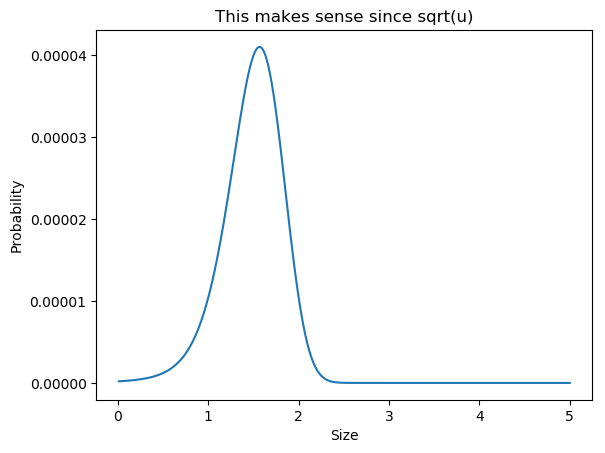

PyObject Text(0.5, 1.0, 'This makes sense since sqrt(u)')

In [47]:
function bayes_posterior(u, Σ, u_prior, Σ_prior, sizes)
    post = zeros(length(sizes))
    sum_sizes = sum(sizes)
    square_sizes = sizes.^2 # <- g(v)
    prior = pdf.(Normal(u_prior, Σ_prior), sizes)
    likelihood = pdf.(Normal(u, Σ), square_sizes) # <- g(v)
    p = (prior .* likelihood) / sum_sizes
    
    return p
end

A = bayes_posterior(u, Σ, u_prior, Σ_prior, sizes);
plot(sizes, A)
xlabel("Size")
ylabel("Probability")
title("This makes sense since sqrt(u)")

## Finding a likely feature value

Using the above example, find a value $\phi$ which maximizes the posterior, i.e. $p(\phi | u) $. Since the denominator in Bayes' formula here does not depend on $\phi$, we can simply look for a value that maximizes the enumerator $p(u)p(u|\phi)$ and treat it as an optimization problem.

1. Take the log of the enumerator and call it F

$$ F = \ln p(\phi) + \ln p(u|\phi) $$

2. Expand the expression, assuming again all the distributions are Normal, by copy-pasting from the paper because it takes too long to type out

<!-- <img src="derivation1.png"> -->

![image](derivation1.png)
3. Get F's derivative

Recall that 
$$\frac{d}{dx} \ln x = \frac{1}{x} $$

But that's irrelevant since none of the expressions containing $\phi$ are in logarithms.

Thus

$$ \frac{dF}{d\phi} = \frac{u_p - \phi}{\Sigma_p} + \frac{u-g(\phi)}{\Sigma_u}g'(\phi)$$

The little $g'(\phi)$ comes from the chain rule

Now this is kinda cool because we see two terms vying for control of the derivative: The influence of the prior and that of the observation, both weighted by their corresponding covariance matrices. 

### Exercise 2

In [85]:
function dF(u_prior, ϕ, Σ_prior, u, Σ_u, func)
    prior_influence = (u_prior - ϕ) / Σ_prior
    obs_influence = (u - func(ϕ)) / Σ_u
    
    func_diff = 2ϕ # cheating a bit
    dF = prior_influence + obs_influence*func_diff
end
    

dF (generic function with 1 method)

In [96]:
ϕ = u_prior
Σ_u = 1
f(x) = x.^2
dF(u_prior, ϕ, Σ_prior, u, Σ_u, f)

-42.0

In [135]:
# Gnarly Euler integration
Δt = 0.01
ϕ = u_prior
phi = []
for t = 1:Δt:5
    df = dF(u_prior, ϕ, Σ_prior, u, Σ_u, f)
    ϕ += Δt*df
    append!(phi, ϕ)
end

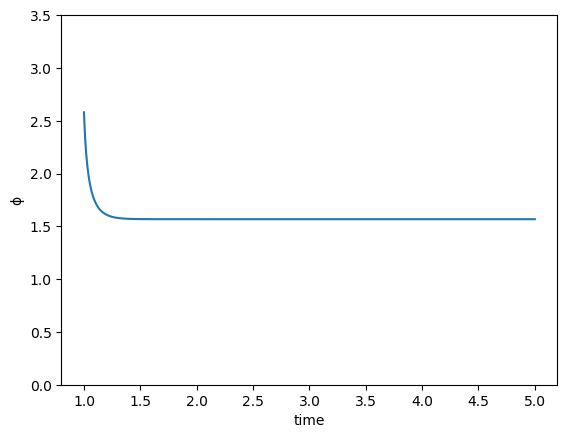

In [136]:
plot(1:Δt:5, phi)
ylim(0, 3.5)
ylabel("ϕ")
xlabel("time");

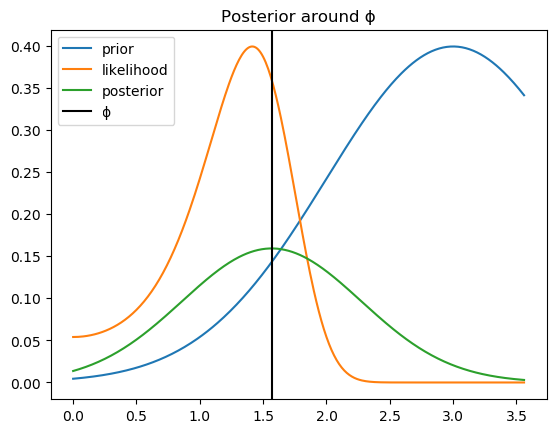

PyObject Text(0.5, 1.0, 'Posterior around ϕ')

In [185]:
# Plugging the value into Bayes' formula:

est_ = ϕ
est_range = 0:0.01:est_+2
# Enumerator
prior = pdf.(Normal(est_, Σ_prior), est_range)
likelihood = pdf.(Normal(est_, Σ_u), est_range)
fN = prior .* likelihood

early_prior = pdf.(Normal(u_prior, Σ_prior), est_range)
early_likelihood = pdf.(Normal(u, Σ_u), est_range.^2)

plot(est_range, early_prior, label="prior")
plot(est_range, early_likelihood, label="likelihood")
plot(est_range, fN, label="posterior")
axvline(est_, color="k", label="ϕ")

legend()
title("Posterior around ϕ")

### Neural implementation

Can split dF into two components of prediction errors:

Deviation from the prior:

$$ E_{prior} = \frac{\phi - v_{prior}}{\Sigma_{prior}} $$

And deviation from the predicted value:

$$ E_u = \frac{u - g(\phi)}{\Sigma_u} $$

And thus $ \phi' = E_u g'(\phi) - E_{prior} $

We could compute the prediction errors incrementally by taking their derivatives

$$ E_p' = \phi - \Sigma_p E_p $$

$$ E_u' = u - g(\phi) - \Sigma_u E_u $$

(Derive)

### Exercise 3

In [211]:
u = 2
Σ = 1
u_prior = 3
ϕ = u_prior

Σ_prior = 1
e_prior = 0
e_u = 0
Σ_u = 1
g(x) = x.^2

dE_prior(ϕ, u_prior, Σ_prior, e_prior) = ϕ - u_prior - Σ_prior*e_prior

dE_u(ϕ, u, Σ_u, e_u) = u - g(ϕ) - Σ_u*e_u

dϕ(e_u, e_prior) = e_u*2ϕ - e_prior

Δt = 0.01
timelength = 8
Ep = []
Eu = []
Φ = []
for t = 1:Δt:timelength
    e_prior += Δt*dE_prior(ϕ, u_prior, Σ_prior, e_prior)
    e_u += Δt*dE_u(ϕ, u, Σ_u, e_u)
    ϕ += Δt*dϕ(e_u, e_prior)
    append!(Ep, e_prior)
    append!(Eu, e_u)
    append!(Φ, ϕ)
end

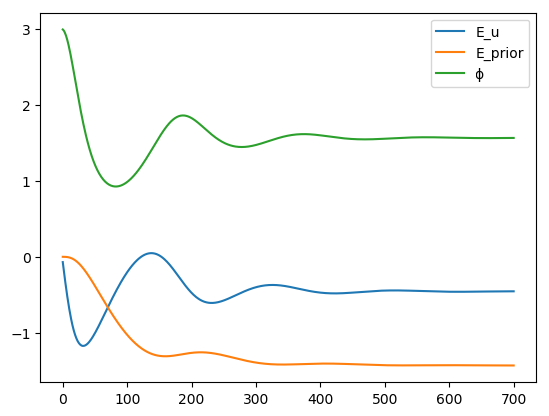

PyObject <matplotlib.legend.Legend object at 0x0000000054D06E80>

In [212]:
plot(Eu, label="E_u")
plot(Ep, label="E_prior")
plot(Φ, label="ϕ")
legend()

We can see that $\phi$ convertes to the correct estimate as before.

## Learning model parameters

$$\frac{\partial F}{\partial v_p} = \frac{\phi - u_p}{\Sigma_p} $$

$$\frac{\partial F}{\partial \Sigma_p} = \frac{1}{2} \big(\frac{(\phi - u_p)^2}{\Sigma_p^2} - \frac{1}{\Sigma_p} \big) $$

$$\frac{\partial F}{\partial \Sigma_u} = \frac{1}{2} \big(\frac{(u - g(\phi))^2}{\Sigma_u^2} - \frac{1}{\Sigma_u} \big) $$

In [177]:
# Stupid things to waste your time with
a(t) = t -> 2t + 1
map(a(2), [1, 2])

2-element Array{Int64,1}:
 3
 5